# Estimate the number of book events missing from the dataset.

Book events almost exclusively tracked through the circulation cards, but how many cards survived is unknown and varies dramatically with time. With this in mind can we estimate the total circulation?

Notes
* We will focus exclusively on dates prior to 1942, which leaves out approximately 2 percent
* Only subscription events with solid start and end dates will be used in calculating the book event estimate. This excludes six percent of subscription events.

In [61]:
import pandas as pd
from datetime import datetime, date, timedelta

%matplotlib inline

In [62]:
MISSING_MEMBERS_ESTIMATE = 0.9856

In [63]:
csv_urls = {
    'members': 'https://dataspace.princeton.edu/bitstream/88435/dsp01b5644v608/2/SCoData_members_v1.1_2021-01.csv',
    'books': 'https://dataspace.princeton.edu/bitstream/88435/dsp016d570067j/2/SCoData_books_v1.1_2021-01.csv',
    'events': 'https://dataspace.princeton.edu/bitstream/88435/dsp012n49t475g/2/SCoData_events_v1.1_2021-01.csv'

}

# load members, books, events as csv
members_df = pd.read_csv(csv_urls['members'])
books_df = pd.read_csv(csv_urls['books'])
events_df = pd.read_csv(csv_urls['events'])


In [64]:
book_events = events_df[~events_df.item_uri.isna()].copy()

print(f"Number of surviving book events: {book_events.shape[0]}")
print(f"Number of book events from logbooks: {book_events[book_events['source_type'] == 'Logbook'].shape[0]}")
print(f"Percent of members have a card: {round(members_df[members_df['has_card']].shape[0] / members_df.shape[0] * 100, 2)}")

# For simplicity, drop empty start dates and events before 1942, which make
#  up a small fraction of the data
book_events['start_date'] = pd.to_datetime(book_events['start_date'], errors='coerce')
book_events = book_events.dropna(subset=['start_date'])
book_events = book_events[book_events['start_date'] < datetime(1942, 1, 1)].copy()

Number of surviving book events: 22479
Number of book events from logbooks: 23
Percent of members have a card: 11.66


# How constant are subscription habits?

Ideally, we'd be able to extrapolate from the borrowing rates of the cards that we have to estimate how many book events we don't have.


count    265.000000
mean       3.831664
std        0.954511
min        1.600000
25%        3.117647
50%        3.750000
75%        4.366667
max        7.500000
Name: book_event_per_active_member, dtype: float64


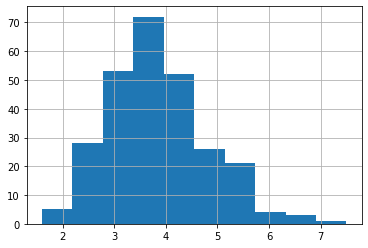

In [65]:
monthly_count = book_events.groupby([pd.Grouper(key='start_date', freq='M')])['event_type'].count()

# for each month get the count of the unique active members
monthly_groups = book_events.groupby([pd.Grouper(key='start_date', freq='M')])
member_count = []
for i, df in monthly_groups:
    # HACK: member_uris is multivalued
    member_count.append([i, df['member_uris'].unique().shape[0]])
    
member_count_df = pd.DataFrame([x[1] for x in member_count], index=pd.to_datetime([x[0] for x in member_count]))

# Get the proportion of book events per active member
member_count_df.columns = ['member_count']
member_count_df['book_events'] = monthly_count
member_count_df['book_event_per_active_member'] = member_count_df['book_events'] / member_count_df['member_count']

print(member_count_df['book_event_per_active_member'].describe())
median_book_events_per_active_member_per_month = member_count_df['book_event_per_active_member'].median()
member_count_df['book_event_per_active_member'].hist()

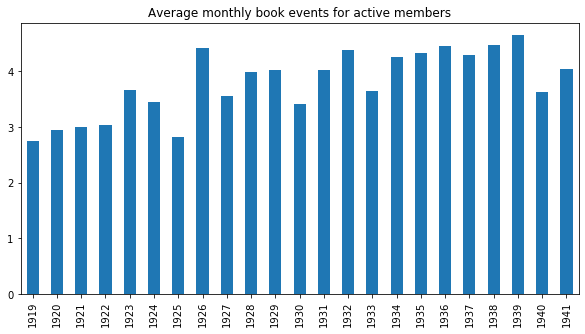

In [66]:
# Confirm that reading habits are consistent over time
proportion_by_year = member_count_df['book_event_per_active_member'].groupby([pd.Grouper(freq='Y')]).mean()
proportion_by_year.index = proportion_by_year.index.year
ax = proportion_by_year.plot(kind='bar', title='Average monthly book events for active members', figsize=(10, 5))
ax

# Apply reading habits to monthly membership


In [67]:
# How many unique active members are mentioned each month in the logbooks?
member_events = events_df[events_df.item_uri.isna()].copy()
member_events['start_date'] = pd.to_datetime(member_events.start_date, errors='coerce')
member_events['end_date'] = pd.to_datetime(member_events.end_date, errors='coerce')

# How many null values occur in start or end date?
print(member_events.start_date.isna().sum())
print(member_events.end_date.isna().sum())
# Drop these
member_events = member_events.dropna(subset=['start_date', 'end_date'])

13
670


In [68]:
def active_count(df_t, d):
    return df_t[(df_t.start_date <= d) & (df_t.end_date >= d)].shape[0]

monthly_membership_count = {}
month_range = pd.date_range('1919-11-01','1941-12-01', freq='MS').tolist()
for month in month_range:
    monthly_membership_count[month] = active_count(member_events, month)
    
estimated_book_event_count = {}
for month, count in monthly_membership_count.items():
    estimated_book_event_count[month] = median_book_events_per_active_member_per_month * count / MISSING_MEMBERS_ESTIMATE

Text(0.5, 0, '')

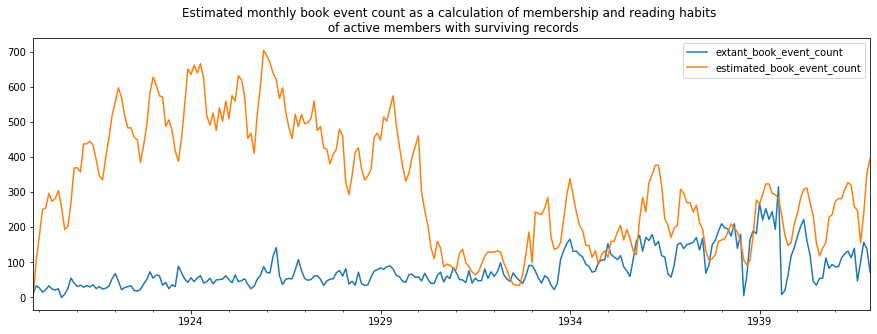

In [69]:
comparison_df = pd.DataFrame(monthly_count)
comparison_df.columns = ['extant_book_event_count']
comparison_df['estimated_book_event_count'] = estimated_book_event_count.values()
ax = comparison_df.plot(figsize=(15, 5), title='Estimated monthly book event count as a calculation of membership and reading habits \n of active members with surviving records')
ax.set_xlabel('')

## Results

In [60]:
surviving_book_event_count = comparison_df['extant_book_event_count'].sum()
total_book_event_count = comparison_df['estimated_book_event_count'].sum() 
percent_surviving_book_events = round(surviving_book_event_count / total_book_event_count * 100, 2)

print(f"Surviving book event count (pre 1942): {surviving_book_event_count}")
print(f"Estimated number of total book events: {int(total_book_event_count)}")
print(f"Estimated proportion of surviving book events: {percent_surviving_book_events}")

Surviving book event count (pre 1942): 21767
Estimated number of total book events: 91130
Estimated proportion of surviving book events: 23.89
